In [1]:
# ==============================================
# COMMON IMPORTS (Run this cell first)
# ==============================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error
import seaborn as sns
import os
import zipfile
import requests
import io

# Set random seeds for reproducibility (optional)
np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow Version:", tf.__version__)
print("Keras Version:", keras.__version__)

/Users/aditya/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


TensorFlow Version: 2.19.0
Keras Version: 3.9.2



--- Assignment 2: Multiclass Classification (OCR Letter Recognition) ---
Download complete.
OCR Dataset loaded successfully.
Dataset head:
   letter  feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0      T          2          8          3          5          1          8   
1      I          5         12          3          7          2         10   
2      D          4         11          6          8          6         10   
3      N          7         11          6          6          3          5   
4      G          2          1          3          1          1          8   

   feature_6  feature_7  feature_8  feature_9  feature_10  feature_11  \
0         13          0          6          6          10           8   
1          5          5          4         13           3           9   
2          6          2          6         10           3           7   
3          9          4          6          4           4          10   
4          6          6  

Model: "ocr_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_softmax (Dense)          │ (None, 26)             │         3,354 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,602 (158.60 KB)

 Trainable params: 40,602 (158.60 KB)

 Non-trainable params: 0 (0.00 B)

Compiling OCR model...
Training OCR model...
Epoch 1/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1822 - loss: 2.8882 - val_accuracy: 0.6069 - val_loss: 1.5765
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5216 - loss: 1.6106 - val_accuracy: 0.7031 - val_loss: 1.0736
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6194 - loss: 1.2416 - val_accuracy: 0.7456 - val_loss: 0.9002
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6681 - loss: 1.0676 - val_accuracy: 0.7756 - val_loss: 0.7917
Epoch 5/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7029 - loss: 0.9583 - val_accuracy: 0.7975 - val_loss: 0.7136
Epoch 6/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7298 - loss: 0.8884 - val_accuracy: 0.8131 - val_loss: 0.6545
Epoch 7/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7479 - loss: 0.8249 - val_accuracy: 0.8250 - val_loss: 0.6077
Epoch 8/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7590 - lo

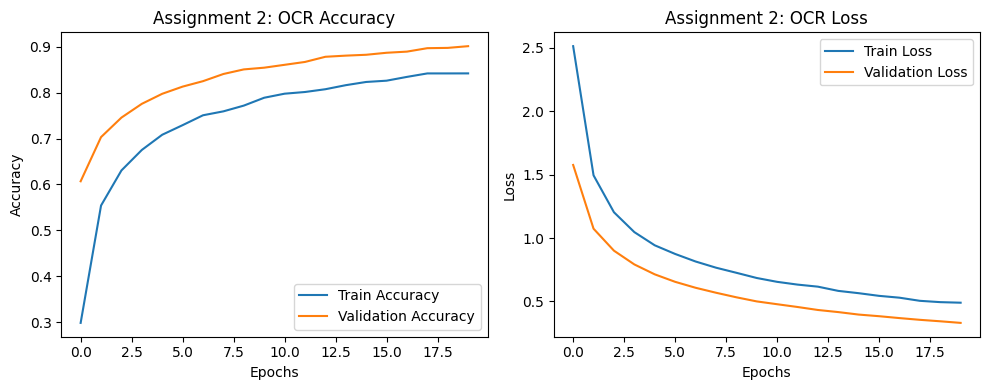

In [2]:
# ==============================================
# Assignment 2: Multiclass Classification (OCR)
# ==============================================
print("\n--- Assignment 2: Multiclass Classification (OCR Letter Recognition) ---")

# --- 1. Load the OCR Dataset ---
# Attempt to download if not present
data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/letter-recognition/letter-recognition.data"
ocr_data_path = "letter-recognition.data"

if not os.path.exists(ocr_data_path):
    print(f"Downloading {ocr_data_path}...")
    try:
        response = requests.get(data_url)
        response.raise_for_status() # Raise an exception for bad status codes
        with open(ocr_data_path, 'w') as f:
            f.write(response.text)
        print("Download complete.")
    except requests.exceptions.RequestException as e:
        print(f"Error downloading dataset: {e}")
        # You might want to stop execution here or handle the error appropriately
        ocr_data = None # Indicate data loading failed
else:
    print(f"Dataset '{ocr_data_path}' found locally.")
    ocr_data = None # Initialize

# Load data using pandas if download succeeded or file exists
if os.path.exists(ocr_data_path):
    try:
        col_names = ['letter'] + [f'feature_{i}' for i in range(16)]
        ocr_data = pd.read_csv(ocr_data_path, header=None, names=col_names)
        print("OCR Dataset loaded successfully.")
        print("Dataset head:\n", ocr_data.head())
        print(f"Dataset shape: {ocr_data.shape}")
    except Exception as e:
        print(f"Error loading dataset with pandas: {e}")
        ocr_data = None # Indicate failure

# Proceed only if data loaded successfully
if ocr_data is not None:
    # --- 2. Preprocess Data ---
    print("Preprocessing OCR data...")
    X = ocr_data.drop('letter', axis=1).values
    y_labels = ocr_data['letter'].values

    # Normalize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Encode labels (A-Z) to integers (0-25) and then one-hot encode
    label_encoder = LabelEncoder()
    y_int = label_encoder.fit_transform(y_labels)
    num_classes_ocr = len(label_encoder.classes_)
    print(f"Number of classes (letters): {num_classes_ocr}")

    onehot_encoder = OneHotEncoder(sparse_output=False) # Use sparse=False for TF < 2.8? Check TF docs.
    y_onehot = onehot_encoder.fit_transform(y_int.reshape(-1, 1))

    # Split Data into Training and Testing Sets
    X_train_ocr, X_test_ocr, y_train_ocr, y_test_ocr = train_test_split(
        X_scaled, y_onehot, test_size=0.2, random_state=42, stratify=y_int # Stratify for balanced classes
    )

    print(f"X_train_ocr shape: {X_train_ocr.shape}")
    print(f"y_train_ocr shape: {y_train_ocr.shape}")

    # --- 3. Define the Model Architecture ---
    print("Building OCR classifier model...")
    model_ocr = keras.Sequential(
        [
            keras.Input(shape=(16,), name="input_features"), # 16 input features
            layers.Dense(256, activation="relu"),
            layers.Dropout(0.4),
            layers.Dense(128, activation="relu"),
            layers.Dropout(0.3),
            layers.Dense(num_classes_ocr, activation="softmax", name="output_softmax"), # 26 output classes
        ],
        name="ocr_classifier"
    )
    model_ocr.summary()

    # --- 4. Compile the Model ---
    print("Compiling OCR model...")
    model_ocr.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

    # --- 5. Train the Model ---
    print("Training OCR model...")
    batch_size_ocr = 256
    epochs_ocr = 20 # Increased epochs might be needed for good performance
    history_ocr = model_ocr.fit(X_train_ocr, y_train_ocr,
                                batch_size=batch_size_ocr,
                                epochs=epochs_ocr,
                                validation_split=0.1,
                                verbose=1) # Show progress

    # --- 6. Evaluate the Model ---
    print("Evaluating OCR model...")
    score_ocr = model_ocr.evaluate(X_test_ocr, y_test_ocr, verbose=0)
    print(f"Test loss: {score_ocr[0]:.4f}")
    print(f"Test accuracy: {score_ocr[1]:.4f}")

    # --- Plot training history (Optional) ---
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history_ocr.history['accuracy'], label='Train Accuracy')
    plt.plot(history_ocr.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Assignment 2: OCR Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history_ocr.history['loss'], label='Train Loss')
    plt.plot(history_ocr.history['val_loss'], label='Validation Loss')
    plt.title('Assignment 2: OCR Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

else:
    print("Skipping Assignment 2 due to data loading issues.")